In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from blimpy import read_header, Waterfall, Filterbank

import sys, os, glob, errno

sys.path.append("../../../setigen/")
import setigen as stg
import generate0

tsamp = 1.4316557653333333
fch1 = 3751.464843051508
df = -1.3969838619232178e-06

fchans = 1024
tchans = 32
fs = np.arange(fch1, fch1 + fchans*df, df)
ts = np.arange(0, tchans*tsamp, tsamp)

In [7]:
# basic cnn training: 1
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf

import time
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.2
# session = tf.Session(config=config)

def format_time(total):
    h = int(np.floor(total / 3600.))
    m = int(np.floor((total - 3600. * h) / 60.))
    s = (total - 3600. * h - 60. * m)
    return '%02dh %02dm %02.2fs' % (h, m, s)

start = time.time()
# dimensions of our images.
img_width, img_height = 32, 1024

model_version = '0'
training_set = '0'

prefix = '/datax/scratch/bbrzycki/training/training%s' % training_set

# Make directory to store different models
model_dir = '%s/models/' % (prefix)
try:
    os.makedirs(model_dir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

train_data_dir = '%s/train/' % (prefix)
validation_data_dir = '%s/validation/' % (prefix)
nb_train_samples = 5000 * 4
nb_validation_samples = 500 * 4
epochs = 50
batch_size = 64

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=callbacks)

model.save_weights(model_dir + '%s_%s.h5' % ('model', model_version))

end = time.time()
print('Saved model! Took %s' % format_time(end - start))



Found 20000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Epoch 1/50
312/312 [==============================] - 370s 1s/step - loss: 0.6177 - acc: 0.7306 - val_loss: 0.3528 - val_acc: 0.8841
Epoch 2/50
312/312 [==============================] - 200s 642ms/step - loss: 0.3344 - acc: 0.8858 - val_loss: 0.2594 - val_acc: 0.9083
Epoch 3/50
312/312 [==============================] - 178s 570ms/step - loss: 0.2623 - acc: 0.9192 - val_loss: 0.2867 - val_acc: 0.8906
Epoch 4/50
312/312 [==============================] - 175s 560ms/step - loss: 0.2388 - acc: 0.9307 - val_loss: 0.1739 - val_acc: 0.9304
Epoch 5/50
312/312 [==============================] - 161s 516ms/step - loss: 0.1992 - acc: 0.9366 - val_loss: 0.1009 - val_acc: 0.9672
Epoch 6/50
312/312 [==============================] - 161s 516ms/step - loss: 0.1777 - acc: 0.9419 - val_loss: 0.0879 - val_acc: 0.9688
Epoch 7/50
312/312 [==============================] - 160s 512ms/step - loss: 0.1678 - acc: 0.9492 - v

In [8]:
# model.load_weights(model_dir + '%s_%s.h5' % ('model', model_version))



In [10]:
generate0.generate_training0_signal('noise')

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 [35, -1.9684570775510972e-05, 8.000000000000001e-06, 10, 0])

In [31]:
from keras.preprocessing.image import img_to_array, load_img

array([[9.9851245e-01, 3.1587676e-26, 1.4874294e-03, 6.6244844e-08]],
      dtype=float32)

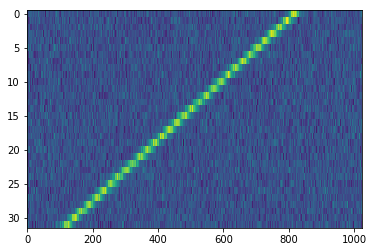

In [49]:
label='constant'
signal, [start_index, drift_rate, line_width, level, spread] = generate0.generate_training0_signal(label=label)
normalized_signal = stg.normalize(stg.inject_noise(signal), cols = 128, exclude = 0.2, use_median=False)
plt.imshow(normalized_signal, aspect='auto')
plt.imsave('temp.png', normalized_signal)

img = load_img('temp.png', False, target_size=(32,1024))
x = img_to_array(img)
x = x / 255.
x = np.expand_dims(x, axis=0)
model.predict_proba(x)

In [65]:
import sklearn.metrics as metrics

test_data_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())   

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

Found 2000 images belonging to 4 classes.
              precision    recall  f1-score   support

    constant       0.98      0.87      0.92       500
       noise       1.00      1.00      1.00       500
scintillated       1.00      0.96      0.98       500
  simple_rfi       0.87      1.00      0.93       500

   micro avg       0.96      0.96      0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [66]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true_classes, predicted_classes)

array([[434,   0,   1,  65],
       [  0, 499,   0,   1],
       [  7,   0, 481,  12],
       [  0,   0,   0, 500]])

In [67]:
predictions.shape

(2000, 4)

In [68]:
test_steps_per_epoch

32

Confusion matrix, without normalization
[[434   0   1  65]
 [  0 499   0   1]
 [  7   0 481  12]
 [  0   0   0 500]]
Normalized confusion matrix
[[0.87 0.   0.   0.13]
 [0.   1.   0.   0.  ]
 [0.01 0.   0.96 0.02]
 [0.   0.   0.   1.  ]]


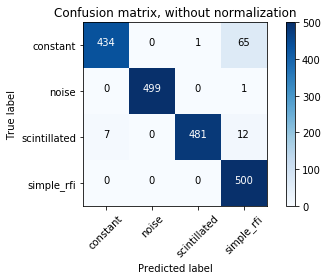

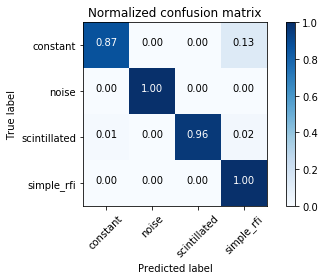

In [69]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(true_classes, predicted_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()